# Load the data

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from tqdm import tqdm  
import pandas as pd
import numpy as np
import random
import glob
import os

folders = ["/Users/majd/Desktop/HEM-Exam/Multivariate Unsupervised/2022_csv",
            "/Users/majd/Desktop/HEM-Exam/Multivariate Unsupervised/2023_csv",
            "/Users/majd/Desktop/HEM-Exam/Multivariate Unsupervised/2024_csv",
            "/Users/majd/Desktop/HEM-Exam/Multivariate Unsupervised/2025_csv"]

temp_df = pd.read_excel("/Users/majd/Desktop/HEM-Exam/Temp Halmstad 20-25 v2.xlsx",usecols=["Unnamed: 0", "Temp oC"])
temp_df.rename(columns={"Unnamed: 0": "time"}, inplace=True)
temp_df["time"] = pd.to_datetime(temp_df["time"])
temp_df.set_index("time", inplace=True)

csv_files = []
for folder in folders:
    csv_files.extend(glob.glob(os.path.join(folder, "*.csv")))

print(f"Found {len(csv_files)} CSV files.")


all_data = []
for file_path in tqdm(csv_files, desc="Processing CSV files"):
    df = pd.read_csv(file_path, sep="\t")
    df["time"] = pd.to_datetime(df["time"])

    df.set_index("time", inplace=True)
    df["consumption[MWh]"] = pd.to_numeric(df["consumption[MWh]"], errors="coerce") #t "-" as nan
    df["Volume[m3]"] = pd.to_numeric(df["Volume[m3]"], errors="coerce")
    df["TemperatureIn"] = pd.to_numeric(df["TemperatureIn"], errors="coerce")
    df["TemperatureOut"] = pd.to_numeric(df["TemperatureOut"], errors="coerce")
    df = df.resample("D").mean()
    
    df["dT"] = df["TemperatureIn"] - df["TemperatureOut"]
    df = df.join(temp_df, how="left")
    file_name = os.path.basename(file_path)
    df["source"] = file_name

    all_data.append(df)

full_df = pd.concat(all_data)
full_df.sort_index(inplace=True)

display(full_df.head())
print(f"Combined shape: {full_df.shape}")

Found 7818 CSV files.


Processing CSV files: 100%|█████████████████| 7818/7818 [01:20<00:00, 97.22it/s]


,consumption[MWh],Volume[m3],TemperatureIn,TemperatureOut,dT,Temp oC,source
time,,,,,,,
2022-01-01,0.033500,0.510833,96.856250,40.186250,56.670000,5.07,735999255020003852_cleaned.csv
2022-01-01,0.096417,1.380833,96.668750,36.373333,60.295417,5.07,735999255020003197_cleaned.csv
2022-01-01,0.011333,0.170833,93.820833,36.934583,56.886250,5.07,735999255020005580_cleaned.csv
2022-01-01,0.004417,0.067917,95.041667,38.666667,56.375000,5.07,735999255020007652_cleaned.csv
2022-01-01,0.055000,0.870833,97.824167,43.245833,54.578333,5.07,735999255020002893_cleaned.csv


Combined shape: (1931178, 7)


# EDA

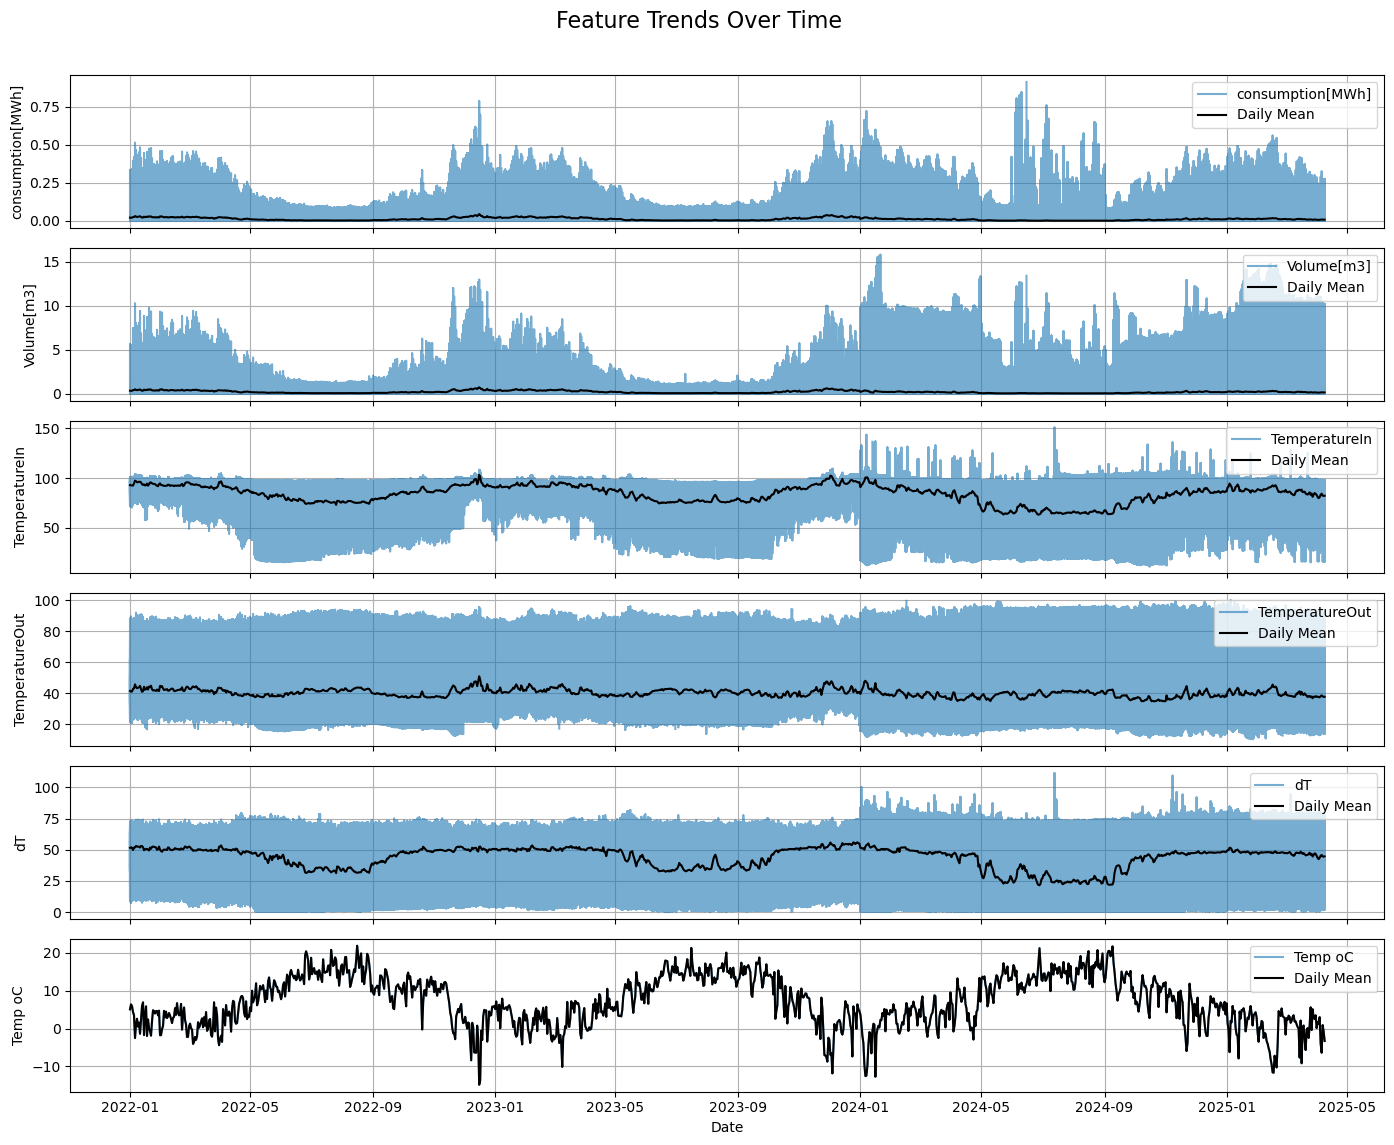

In [4]:
feature_cols = [col for col in full_df.columns if col not in ["source"] and full_df[col].dtype in [float, int]]

n_features = len(feature_cols)
fig, axes = plt.subplots(n_features, 1, figsize=(14, 4 * 3), sharex=True)

if n_features == 1:
    axes = [axes]  # Ensure axes is iterable for 1 feature

for i, col in enumerate(feature_cols):
    axes[i].plot(full_df.index, full_df[col], label=col, alpha=0.6)
    
    daily_mean = full_df.groupby(full_df.index.date)[col].mean()
    axes[i].plot(daily_mean.index, daily_mean.values, c="black",label="Daily Mean")
    
    axes[i].set_ylabel(col)
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

axes[-1].set_xlabel("Date")
fig.suptitle("Feature Trends Over Time", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [5]:
train = full_df[: "2024-05-31"]
val = full_df["2024-06-01" : "2024-12-31"] 
test = full_df["2025-01-01" :]

# Inject Anomalies on Val

In [7]:
def inject_anomalies(df, n=5, duration=7, dataset_name="val", seed=42):
    df = df.copy()
    np.random.seed(seed)
    random.seed(seed)
    df["is_anomaly"] = 0
    anomaly_log = []
    anomaly_types = ["amplitude", "extremum", "mean", "trend", "platform", "pattern", "pattern_shift", "variance", "shift_30", "shift_50"]
    selected_buildings = np.random.choice(df["source"].unique(), size=n, replace=False)
    candidate_cols=["consumption[MWh]", "Volume[m3]", "dT"]
    candidate_cols=["Volume[m3]", "dT"]

    for building_name in selected_buildings:
        subset = df[df["source"] == building_name]
        feature = random.choice(candidate_cols)
        anomaly_type = random.choice(anomaly_types)
        start_idx = np.random.randint(0, len(subset) - duration)
        dates = subset.index[start_idx : start_idx + duration]
        mask = (df["source"] == building_name) & (df.index.isin(dates))
        target_rows = df.loc[mask, feature]
        if target_rows.isna().all() or len(target_rows) != duration:
            continue
            
        orig_values = target_rows.copy()
        std = orig_values.std()
        mean = orig_values.mean()

        if anomaly_type == "amplitude":
            spike_day = random.choice(dates)
            if spike_day in df.index:
                df.at[spike_day, feature] += 6 * std
        elif anomaly_type == "extremum":
            extreme_value = random.choice([orig_values.min() - 6 * std,orig_values.max() + 6 * std])
            df.loc[mask, feature] = extreme_value
        elif anomaly_type == "mean":
            df.loc[mask, feature] = orig_values.values + 6 * std
        elif anomaly_type == "trend":
            trend = np.linspace(-6 * std, 6 * std, duration)
            df.loc[mask, feature] = orig_values.values + trend
        elif anomaly_type == "platform":
            df.loc[mask, feature] = mean 
        elif anomaly_type == "pattern":
            pattern = np.array([1, 0.5, 1.5, 1, 0.5, 1.5, 1]) * 6 * mean
            df.loc[mask, feature] = pattern
        elif anomaly_type == "pattern_shift":
            phase = random.uniform(0, 2*np.pi)
            sine_pattern = np.sin(np.linspace(0, 2*np.pi, duration) + phase)
            df.loc[mask, feature] = orig_values.values + sine_pattern *6* std
        elif anomaly_type == "variance":
            noise = np.random.normal(0, std * 6, size=duration)
            df.loc[mask, feature] = orig_values.values + noise
        elif anomaly_type == "shift_30":
            factor = random.choice([0.7, 1.3])
            df.loc[mask, feature] = orig_values.values * factor
        elif anomaly_type == "shift_50":
            factor = random.choice([0.5, 1.5])
            df.loc[mask, feature] = orig_values.values * factor
        df.loc[mask, "is_anomaly"] = 1
        anomaly_log.append({"building": building_name,
                            "dataset": dataset_name,
                            "feature": feature,
                            "anomaly_type": anomaly_type,
                            "start_date": dates[0],
                            "end_date": dates[-1],
                            "original_mean": mean,
                            "injected_mean": df.loc[mask, feature].mean()})
        
    return df, pd.DataFrame(anomaly_log)


inj_val, val_log = inject_anomalies(val, n=200, dataset_name="val", seed=42)
inj_test, test_log = inject_anomalies(test, n=200, dataset_name="test", seed=42)
anomaly_log = pd.concat([val_log, test_log], ignore_index=True)


# Scale 

In [9]:
scaled_train_list, scaled_val_list, scaled_test_list = [], [], []
scalers = {}

for source in tqdm(full_df["source"].unique(), desc="Scaling per building"):
    train_group = train[train["source"] == source]
    val_group = inj_val[inj_val["source"] == source]
    test_group = inj_test[inj_test["source"] == source]

    #get the min max values from the train data
    scaler = MinMaxScaler()
    scaler.fit(train_group[feature_cols])
    scalers[source] = scaler
    train_scaled = pd.DataFrame(scaler.transform(train_group[feature_cols]),columns=feature_cols, index=train_group.index)
    train_scaled = train_scaled.join(train_group.drop(columns=feature_cols))
    scaled_train_list.append(train_scaled)
    
    #use the min max values from train on val and test to simulate the real life scenario 
    if not val_group.empty:
        val_scaled = pd.DataFrame(scaler.transform(val_group[feature_cols]), columns=feature_cols, index=val_group.index)
        val_scaled = val_scaled.join(val_group.drop(columns=feature_cols))
        scaled_val_list.append(val_scaled)

    if not test_group.empty:
        test_scaled = pd.DataFrame(scaler.transform(test_group[feature_cols]), columns=feature_cols, index=test_group.index)
        test_scaled = test_scaled.join(test_group.drop(columns=feature_cols))
        scaled_test_list.append(test_scaled)

train_scaled_df = pd.concat(scaled_train_list)
val_scaled_df = pd.concat(scaled_val_list)
test_scaled_df = pd.concat(scaled_test_list)


Scaling per building: 100%|█████████████████| 3660/3660 [03:38<00:00, 16.73it/s]


# KNN

In [11]:
# Shared setup
feature_cols = ["consumption[MWh]", "Volume[m3]", "dT", "Temp oC"]

def walk_forward(rolling_train, rolling_eval, eval_days, threshold_quantile=0.9998):
    scored_df = pd.DataFrame()
    train_min_day = rolling_train.index.min()

    for day in eval_days:
        test_day = day
        train_max_day = rolling_train.index.max()
        print(f"Train: {train_min_day.date()} - {train_max_day.date()}  | Eval day: {test_day.date()}")

        current_day_data = rolling_eval[rolling_eval.index == day]
        rolling_train = pd.concat([rolling_train, current_day_data]).dropna()

        X = rolling_train.loc[(rolling_train.index >= train_min_day) & (rolling_train.index < test_day)]
        score = rolling_train.loc[rolling_train.index == test_day]

        knn = NearestNeighbors(n_neighbors=1)
        knn.fit(X[feature_cols].values)
        distances, _ = knn.kneighbors(score[feature_cols].values)

        score = score.copy()
        score["anomaly_score"] = distances.flatten()
        scored_df = pd.concat([scored_df, score])

    threshold = scored_df["anomaly_score"].quantile(threshold_quantile)
    scored_df["high_score"] = (scored_df["anomaly_score"] > threshold).astype(int)
    scored_df["predicted_anomaly"] = 0

    for building in scored_df["source"].unique():
        building_df = scored_df[scored_df["source"] == building].sort_index()
        rolling_sum = building_df["high_score"].rolling(window=7, min_periods=7).sum()
        high_anomaly_period = (rolling_sum == 7)
        scored_df.loc[high_anomaly_period[high_anomaly_period].index, "predicted_anomaly"] = 1

    return scored_df

# Validation 

In [13]:
rolling_train_val = train_scaled_df[feature_cols + ["source"]].copy()
rolling_train_val["is_anomaly"] = 0
rolling_val = val_scaled_df[feature_cols + ["source", "is_anomaly"]].copy()
val_days = sorted(rolling_val.index.unique())

scored_val_df = walk_forward(rolling_train_val, rolling_val, val_days)

Train: 2022-01-01 - 2024-05-31  | Eval day: 2024-06-01
Train: 2022-01-01 - 2024-06-01  | Eval day: 2024-06-02
Train: 2022-01-01 - 2024-06-02  | Eval day: 2024-06-03
Train: 2022-01-01 - 2024-06-03  | Eval day: 2024-06-04
Train: 2022-01-01 - 2024-06-04  | Eval day: 2024-06-05
Train: 2022-01-01 - 2024-06-05  | Eval day: 2024-06-06
Train: 2022-01-01 - 2024-06-06  | Eval day: 2024-06-07
Train: 2022-01-01 - 2024-06-07  | Eval day: 2024-06-08
Train: 2022-01-01 - 2024-06-08  | Eval day: 2024-06-09
Train: 2022-01-01 - 2024-06-09  | Eval day: 2024-06-10
Train: 2022-01-01 - 2024-06-10  | Eval day: 2024-06-11
Train: 2022-01-01 - 2024-06-11  | Eval day: 2024-06-12
Train: 2022-01-01 - 2024-06-12  | Eval day: 2024-06-13
Train: 2022-01-01 - 2024-06-13  | Eval day: 2024-06-14
Train: 2022-01-01 - 2024-06-14  | Eval day: 2024-06-15
Train: 2022-01-01 - 2024-06-15  | Eval day: 2024-06-16
Train: 2022-01-01 - 2024-06-16  | Eval day: 2024-06-17
Train: 2022-01-01 - 2024-06-17  | Eval day: 2024-06-18
Train: 202

In [14]:
y_true = scored_val_df["is_anomaly"]
y_pred = scored_val_df["predicted_anomaly"]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Test Phase

In [16]:
rolling_train_test = pd.concat([train_scaled_df, val_scaled_df])[feature_cols + ["source"]].copy()
rolling_train_test["is_anomaly"] = 0
rolling_test = test_scaled_df[feature_cols + ["source", "is_anomaly"]].copy()
test_days = sorted(rolling_test.index.unique())

scored_test_df = walk_forward(rolling_train_test, rolling_test, test_days)

Train: 2022-01-01 - 2024-12-31  | Eval day: 2025-01-01
Train: 2022-01-01 - 2025-01-01  | Eval day: 2025-01-02
Train: 2022-01-01 - 2025-01-02  | Eval day: 2025-01-03
Train: 2022-01-01 - 2025-01-03  | Eval day: 2025-01-04
Train: 2022-01-01 - 2025-01-04  | Eval day: 2025-01-05
Train: 2022-01-01 - 2025-01-05  | Eval day: 2025-01-06
Train: 2022-01-01 - 2025-01-06  | Eval day: 2025-01-07
Train: 2022-01-01 - 2025-01-07  | Eval day: 2025-01-08
Train: 2022-01-01 - 2025-01-08  | Eval day: 2025-01-09
Train: 2022-01-01 - 2025-01-09  | Eval day: 2025-01-10
Train: 2022-01-01 - 2025-01-10  | Eval day: 2025-01-11
Train: 2022-01-01 - 2025-01-11  | Eval day: 2025-01-12
Train: 2022-01-01 - 2025-01-12  | Eval day: 2025-01-13
Train: 2022-01-01 - 2025-01-13  | Eval day: 2025-01-14
Train: 2022-01-01 - 2025-01-14  | Eval day: 2025-01-15
Train: 2022-01-01 - 2025-01-15  | Eval day: 2025-01-16
Train: 2022-01-01 - 2025-01-16  | Eval day: 2025-01-17
Train: 2022-01-01 - 2025-01-17  | Eval day: 2025-01-18
Train: 202

In [17]:
y_true = scored_test_df["is_anomaly"]
y_pred = scored_test_df["predicted_anomaly"]

recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f"Test Recall: {recall:.3f}")
print(f"Test precision: {precision:.3f}")

Test Recall: 0.353
Test precision: 0.774
